# Магнитное поле на оси кругового тока

Рассмотрим кольцо радиуса $R$, по которому течёт постоянный ток величиной $I$. Нужно определить магнитную индукцию $B$ на оси, проходящей через центр кольца.

![схема](pics/magnetic-ring.png)

Как и в случае с прямым проводником, представим кольцо как набор $N$ элементарных участков тока $d\vec{l}$. Вектор магнитной индукции в точке A$(x,y,z)$ от элемента проводника согласно закону Био — Савара — Лапласа определяется выражением:
  $$d\vec{B}(x,y,z) = \frac{\mu_0}{4\pi} \frac{I [\vec{r} \times d\vec{l}] }{r^3},$$ 
где $\vec{r}$ — радиус-вектор элемента проводника, направленный от точки наблюдения A; $\left[ \vec{r} \times d\vec{l} \right]$ — векторное произведение; $\mu_0 = 1.2566 \cdot 10^{-6}$ Гн/м — магнитная постоянная.

Пусть элемент проводника $d\vec{l}$ расположен между точками с координатами $(x_i,y_i,z_i)$ и $(x_{i-1}, y_{i-1}, z_{i-1})$ в декартовой системе координат, т.е.
$$d\vec{l} = \left\{x_i - x_{i-1}, y_i - y_{i-1}, z_i - z_{i-1} \right\}.$$
Его радиус-вектор из точки наблюдения A$(x,y,z)$ определяется координатами
$$\vec{r} = \left\{ \frac{x_i + x_{i-1}}{2} - x, \frac{y_i + y_{i-1}}{2} - y, \frac{z_i + z_{i-1}}{2} - z \right\}.$$

Вектор магнитной индукции от $N$ элементов кольцевого проводника является суперпозицией индукций, создаваемых его элементарными участками:

$$\vec{B}(x,y,z) = \sum_{i=1}^N d\vec{B}(x,y,z) = \frac{\mu_0 I}{4\pi} \sum_{i=1}^N \frac{[ \vec{r} \times d\vec{l}]}{r^3}$$

## Подготовка вычислений

Начнём с импорта библиотек, которыми мы будем пользоваться в блокноте: `NumPy` для работы с массивами и `Matplotlib` для визуализации.

Предварительно выполним команду `%matplotlib inline`, специфичную для Jupyter (т.н. *magic command*), которая обеспечит встраивание графиков по месту, непосредственно в блокнот.

In [1]:
import numpy as np

# отображение графиков внутри блокнота (вызывать ПЕРЕД импортом библиотеки)
%matplotlib inline
import matplotlib.pyplot as plt

### Кольцевой проводник с током
Определим класс `WireElement`, описывающий элемент проводника, такой же как в случае с прямым проводником. Как и ранее, полями класса будут координаты опорных точек `xyz_start` и `xyz_end`, величина тока `I`, а также метод `dB()` для вычисления элементарного вектора магнитной индукции $d\vec{B}$.

In [2]:
# Магнитная постоянная
mu0 = 1.2566e-6

class WireElement:
    """
    Элемент проводника
    """
    def __init__(self, I, xyz_start, xyz_end):
        """
        Задание величины тока и местоположения элемента проводника
        
        Параметры
        ---------
        I: float
            величина электрического тока.
        xyz_start, xyz_end: numpy array float
            {x,y,z}-координаты начала и конца элемента.
        """
        self.I = I
        self.xyz_start = xyz_start
        self.xyz_end   = xyz_end
        
    def dB(self, XYZ):
        """
        Вычислить компоненты вектора магнитной индукции во всех узлах сетки
        от данного элемента проводника
        
        Параметры
        ---------
        XYZ: numpy array
            массив координат {x,y,z} узлов сетки.
        """
        
        # Вектор, задающий элемент проводника
        dl = self.xyz_end - self.xyz_start
        
        # Радиус-вектора до элемента проводника от каждого из узлов сетки
        r  = 0.5*(self.xyz_end + self.xyz_start) - XYZ
        
        # Длины радиус векторов
        rlen = np.linalg.norm(r, axis=3, keepdims=True)
        
        return  mu0/(4*np.pi) * self.I * np.cross(r, dl) / rlen**3

Расположим кольцо радиуса $R$ в плоскости $z=0$, центр кольца поместим в начало координат $(0,0,0)$. Зададим величину текущего по польцу тока $I = 1.0$ и число элементарных участков тока $N$. Создадим проводник как массив из его элементарных частей.

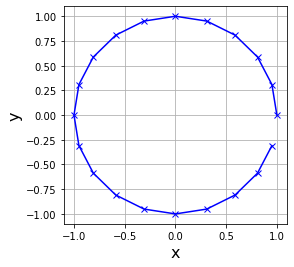

In [3]:
wire_R = 1.0   # радиус кольцевого проводника
wire_I = 1.0   # ток проводника
wire_N = 20    # число элементарных частей

def make_wire():
    # угловая координата в радианах
    theta_start = 0.0
    theta_end   = 2*np.pi
    theta_step  = (theta_end - theta_start) / wire_N

    def xyz(theta):
        """Декартовы координаты из угловой"""
        x = wire_R * np.cos(theta)
        y = wire_R * np.sin(theta)
        z = 0.0
        return np.array( (x,y,z) )
    
    wire = []
    theta = theta_start
    for i in range(0, wire_N):
        theta_im1, theta_i = theta, theta + theta_step  # точка i-1 и i на проводе
        wire.append( WireElement(wire_I, xyz(theta_im1), xyz(theta_i)) )
        theta = theta_i

    return wire

wire_Elements = make_wire()

# рисуем кольцо
def show_ring():
    plt.figure(figsize=(4, 4))
    plt.grid(True)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    
    xy = np.array([ el.xyz_start for el in wire_Elements ]).T
    plt.plot(xy[0], xy[1], color='b', linestyle='-', marker='x')

show_ring()

### Расчётная сетка
Определим трёхмерную декартовую сетку, состоящую из равномерно распределённых узлов. В качестве расчётной области выберем прямоугольный параллелепипед со сторонами $x,y,z \in \left[-2,2\right],\left[-2,2\right],\left[-2,2\right]$. Границы расчетной области обозначим переменными `{x,y,z}_start` и `{x,y,z}_end`, а число узлов вдоль каждого направления — `grid_N{x,y,z}`.

Сетка создаётся с помощью специального объекта `numpy.mgrid[start:end:step,...]`, который генерирует координаты узлов с равномерным распределением от `start` до `end` с шагом `step`. Причём eсли `step = N*1j` (мнимая комплексная величина), то он определяется числом точек разбиения `N`.

Координаты сеточных узлов хранятся в 4х-мерном массиве `grid_XYZ` размерностью `(Nx, Ny, Nz, 3)`, где `N*` — число узлов вдоль каждого направления, 3 — число значений в каждом узле (координаты $x$, $y$ и $z$).

In [4]:
# Границы расчётной области
x_start, x_end = -2.0,  2.0            
y_start, y_end = -2.0,  2.0
z_start, z_end = -2.0,  2.0

# Число узлов сетки в каждом направлении
grid_Nx, grid_Ny, grid_Nz = 21, 21, 21

def make_grid():
    # 3D массивы координат узлов сетки,
    # каждый размерностью (grid_Ny, grid_Nx, grid_Nz) (sic!)
    X, Y, Z = np.mgrid[x_start:x_end:grid_Nx*1j,
                       y_start:y_end:grid_Ny*1j,
                       z_start:y_end:grid_Nz*1j]

    # Объединённый 4D массив координат: [ {x0,y0,z0}, {x1,y1,z1}, ... ]
    return np.stack( (X, Y, Z), axis=3 )

grid_XYZ = make_grid()

## Вычисления и результаты

Для начала инициализируем нулями массив для $x-$, $y-$ и $z-$ компонент индукции результирующего магнитного поля. Затем просуммируем в цикле индукции от каждого элементарного участка провода.

In [5]:
B = np.zeros_like(grid_XYZ)

for el in wire_Elements:
    B = B + el.dB(grid_XYZ)

Визуализируем поле как трёхмерное векторное, где длина вектора пропорциональна величина магнитной индукции.

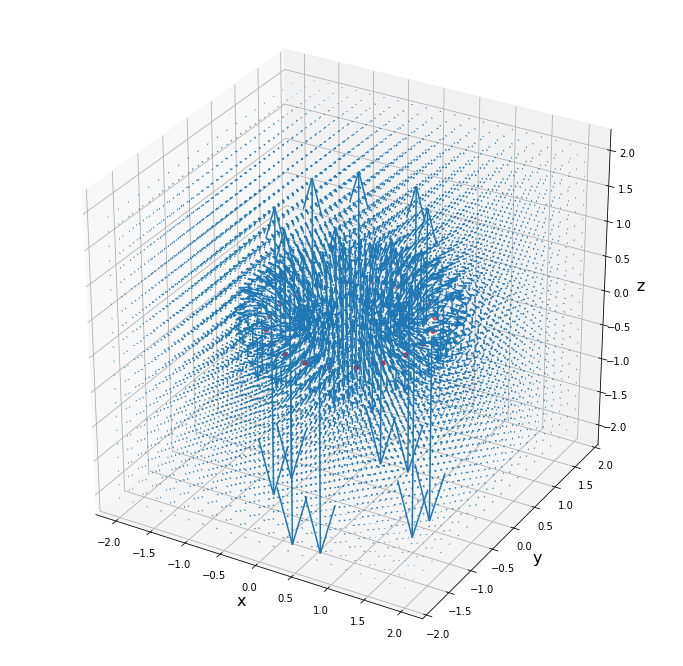

In [6]:
from mpl_toolkits.mplot3d import Axes3D

def make_vec_plot_3D():
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')

    ax.set_xlabel('x',fontsize=16)
    ax.set_ylabel('y',fontsize=16)
    ax.set_zlabel('z',fontsize=16)
    
    ax.set_ylim(y_start,y_end)

    # Векторное поле магнитной индукции
    X,Y,Z    = ( grid_XYZ[...,c] for c in (0,1,2) )
    Bx,By,Bz = (        B[...,c] for c in (0,1,2) )
    ax.quiver(X, Y, Z, Bx, By, Bz, length=0.5/mu0)

    # Точки, отмечающие элементарные участки провода
    xyz = np.array( [el.xyz_start for el in wire_Elements] ).T
    ax.scatter(xyz[0],xyz[1],xyz[2], color='r', marker='o')
    
make_vec_plot_3D()

К сожалению, результат несколько зашумлён. В целом видно, что магнитное поле закручивается вокруг провода и падает с расстоянием (уменьшается длина стрелок), но также сильно выделяются по длине некоторые из стрелок. Увеличенная длина соответствуют большой величине магнитной индукции вблизи провода, когда знаменатель в формуле для $B$ приближается к нулю.

Кроме того, из рисунка можно заметить осевую симметрию поля, так что магнитные линии повторяются в любом плоском сечении проходящем через ось кольца $z$. Поэтому для более наглядного представления можно построить распределение магинтного поля например в плоскости $xz$ при $y=0$. Для этого нужно вычленить из численного решения (4х-мерных массивов `B` и `grid_XYZ`) срезы вдоль $y=0$. В нашем случае этой линии соответствует серединный индекс сетки `j = grid_Ny//2` (используем целочисленное деление). Тогда данные в соответствии с синтаксисом `NumPy` извлекаются как `[:,j,:, c]`.

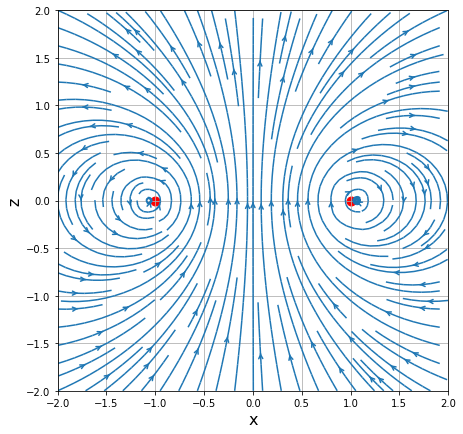

In [7]:
def show_2D_xz():
    plt.figure(figsize=(7,7))
    plt.grid(True)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('z', fontsize=16)
    plt.xlim(x_start, x_end)
    plt.ylim(z_start, z_end)
    
    # Метки кольцевого провода, пересекающего плоскость x=0
    plt.scatter([-wire_R, wire_R], [0,0], color='r', s=80, marker='o');
    
    # Координаты узлов сетки и значение магнитной индукции в плоскости x=0
    X, Z   = ( grid_XYZ[:, grid_Ny//2, :, c].T for c in (0,2) )
    Bx, Bz = (        B[:, grid_Ny//2, :, c].T for c in (0,2) )

    return plt.streamplot(X,Z, Bx,Bz, density=1.5, arrowstyle='->')

plot_stream = show_2D_xz()

Получившийся срез можно отобразить в трехмерном представлении:

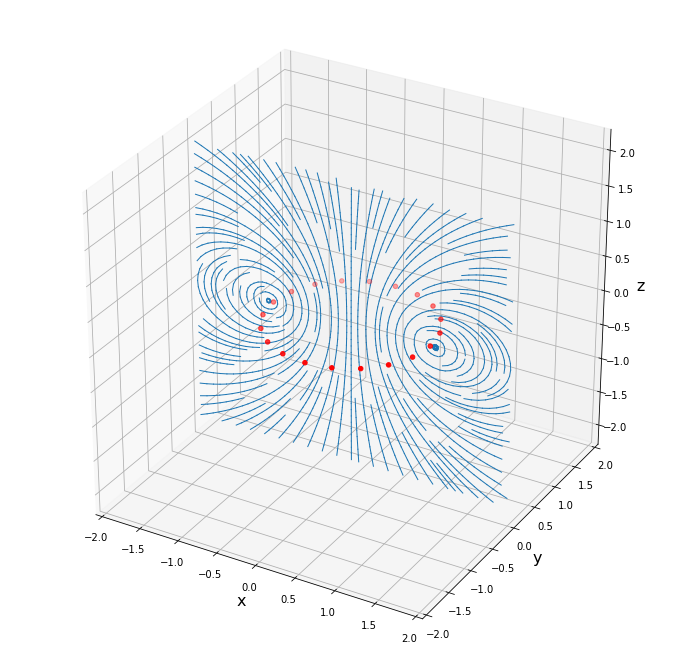

In [8]:
from mpl_toolkits.mplot3d import art3d

def make_stream_plot3D(stream2D):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(x_start,x_end)
    ax.set_ylim(y_start,y_end)

    ax.set_xlabel('x',fontsize=16)
    ax.set_ylabel('y',fontsize=16)
    ax.set_zlabel('z',fontsize=16)

    # Точки, отмечающие элементарные участки провода
    xyz = np.array( [el.xyz_start for el in wire_Elements] ).T
    ax.scatter(xyz[0],xyz[1],xyz[2], color='r', marker='o')    
    
    for line in stream2D.lines.get_paths():
        x = line.vertices.T[0]
        y = np.zeros_like(x)
        z = line.vertices.T[1]
    
        ax.plot(x, y, z, linewidth=1, color='#1f77b4')
    #
    
make_stream_plot3D(plot_stream)

### Оценка точности

Теоретическое значение величины магнитной индукции на оси $z$ кольцевого проводника радиуса $R$ записывается как:
$$B(z) = \frac{\mu_0}{2} \frac{I R^2}{ \sqrt{(z^2 + R^2)^3} }$$

Оформим это в виде функции:

In [9]:
def Bz_theor(I, z):
    with np.errstate(divide='ignore'):  # убираем предупреждение о делении на ноль
        return mu0/2 * I * wire_R**2 / (z**2 + wire_R**2)**1.5

Для выполнения сравнения с теоретическим решением, извлечём из численного решения срезы данных вдоль линии $x=0, y=0$. Этой линии соответствуют центральные индексы сетки `i = grid_Nx//2` и `j = grid_Ny//2` (используем целочисленное деление). Тогда в рамках синтаксиса `NumPy` и согласно порядка индексации наших 4х-мерных массивов, данные извлекаются как `[i,j,:, c]`.

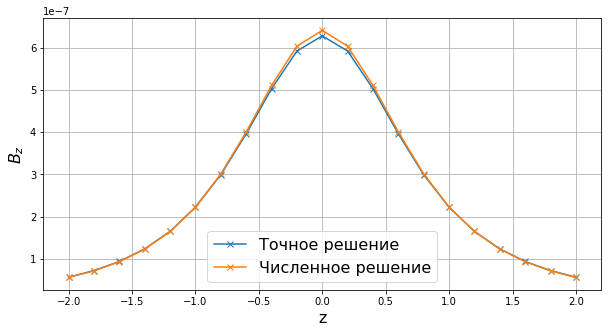

In [10]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.xlabel('z', fontsize=16)
plt.ylabel('$B_z$', fontsize=16)

# Координаты узлов сетки и значение магнитной индукции вдоль направления (x=0,y=0,z)
Z  = grid_XYZ[grid_Nx//2, grid_Ny//2, :, 2]
Bz =        B[grid_Nx//2, grid_Ny//2, :, 2]

plt.plot(Z, Bz_theor(wire_I, Z), label = 'Точное решение', marker='x' )
plt.plot(Z, Bz, label = 'Численное решение', marker='x' )
plt.legend(fontsize=16);

Можно вычислить относительную ошибку решения $\varepsilon$ – просто возьмем абсолютную величину разницы численного и точного решений и отнормируем на само решение.

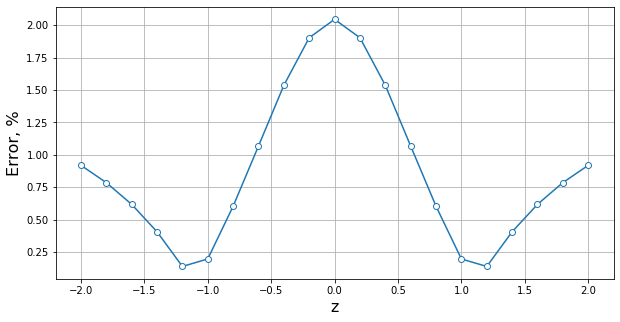

In [11]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.xlabel('z', fontsize=16)
plt.ylabel('Error, %', fontsize=16)
plt.plot(Z, abs( (Bz_theor(wire_I, Z) - Bz)/Bz ) * 100, marker='o', markerfacecolor='w');

## Задание

Измените число элементарных участков, при помощи которых мы моделируем кольцевой провод и число точек расчётной сетки. Посмотрите, как будет меняться ошибка вычислений.